# TODO: WaveNet
1. Write Embedding, Flatten, Sequential components.
2. Write a rolling window loss plot.
3. Why go bigger and deeper? MLP training loss and validation loss are close to each other, which means we are not overfitting.
4. WaveNet motivation: don't want to squash all information into a single embedding in just the first layer, but rather want do it layer by layer.
5. Implementation: 
   1. Use consecutive version of Flatten() to concat bigrams layer by layer.
   2. Fix BatchNorm bug because it is not working correctly with the multiple dimensions (>2) of the input.

In [1]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
import random

# Data preparation

In [2]:
words = open("../names.txt", "r").read().splitlines()
chars = sorted(set('.'.join(words)))
stoi = {char:i for i, char in enumerate(chars)}
itos = {i:char for i, char in enumerate(chars)}

In [3]:
ratio1 = 0.8
ratio2 = 0.9
chunk = 8

def create_data(ws, chunk=3):
    X = []
    Y = []
    
    for word in ws:
        Xt = [0] * chunk # Cool
        for ch in word + '.': # Dont forget to add ending token.
            X.append(Xt)
            Y.append(stoi[ch])   
            Xt = Xt[1:] + [stoi[ch]]

    return torch.tensor(X), torch.tensor(Y)

random.shuffle(words) # No obvious affect (original words already shuffled)
n1 = int(ratio1 * len(words))
n2 = int(ratio2 * len(words))
Xt, Yt = create_data(words[:n1], chunk=chunk)
Xdev, Ydev = create_data(words[n1:n2], chunk=chunk)
Xte, Yte = create_data(words[n2:], chunk=chunk)
print(Xt.shape)
print(Xdev.shape)

torch.Size([182439, 8])
torch.Size([22758, 8])


# Construct the component classes

In [4]:
class Linear:
    def __init__(self, n_in, n_out, bias=True):
        self.n_in = n_in
        self.n_out = n_out
        self.W = torch.randn((n_in, n_out)) * (n_in)**(-0.5)
        self.b = torch.zeros(n_out) if bias else None # zeros
        self.out = None # For visualization

    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out   

    def parameters(self):
        return [self.W, self.b] if self.b is not None else [self.W]
    
    def __repr__(self):
        return f"Linear({self.n_in}, {self.n_out})"

test_linear = Linear(10, 50)
x_test = torch.randn((32, 10))
print(test_linear(x_test).shape)
print(test_linear.parameters()[0].shape)

torch.Size([32, 50])
torch.Size([10, 50])


In [11]:
class BN1d:
    def __init__(self, num_feat, eps=1e-5, momentum=0.1):
        self.n_feat = num_feat
        self.eps = eps
        self.momentum = momentum

        self.gamma = torch.ones(num_feat) # ones
        self.beta = torch.zeros(num_feat) # zeros

        self.training = True
        self.rmean = torch.zeros(num_feat) # !! torch.zeros not torch.ones. It is like starting from a normal distribution.
        self.rvar = torch.ones(num_feat)

        self.out = None

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            meani = torch.mean(x, dim=dim, keepdim=True) 
            vari = torch.var(x, dim=dim, keepdim=True)
        else:
            meani = self.rmean
            vari = self.rvar
        
        if self.training: # !! During training
            with torch.no_grad(): # !! Remember to torch.no_grad()
                self.rmean = (1- self.momentum) * self.rmean + self.momentum * meani 
                self.rvar = (1 - self.momentum) * self.rvar + self.momentum * vari
        
        self.out = self.gamma * (x - meani) / torch.sqrt(vari + self.eps) + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
    def __repr__(self):
        return f"BN1d({self.n_feat})"

BN_test = BN1d(4)
x_test = torch.randn((5, 4))
print(BN_test(x_test))
print((x_test - x_test.mean(0, keepdim=True))/(torch.sqrt(x_test.var(0, keepdim=True) + 1e-5)))

tensor([[-0.5969, -0.8527,  0.2994, -0.3505],
        [-1.2799, -0.7984,  0.8993,  0.5766],
        [ 0.3171, -0.2241, -1.4822, -1.1667],
        [ 1.3667,  1.5806,  0.7992, -0.4627],
        [ 0.1930,  0.2946, -0.5156,  1.4033]])
tensor([[-0.5969, -0.8527,  0.2994, -0.3505],
        [-1.2799, -0.7984,  0.8993,  0.5766],
        [ 0.3171, -0.2241, -1.4822, -1.1667],
        [ 1.3667,  1.5806,  0.7992, -0.4627],
        [ 0.1930,  0.2946, -0.5156,  1.4033]])


In [12]:
class Tanh:
    def __init__(self):
        self.out = None

    def __call__(self, x):
        self.out = torch.tanh(x)       
        return self.out

    def parameters(self):
        return []
    
    def __repr__(self):
        return "Tanh()"

In [13]:
class Embedding:
    def __init__(self, num_embedding, embedding_dim):
        self.C = torch.randn((num_embedding, embedding_dim))
        self.num_emb = num_embedding
        self.emb_dim = embedding_dim

    def __call__(self, ix):
        self.out = self.C[ix]
        return self.out

    def parameters(self):
        return [self.C]

    def __repr__(self):
        return f"Embedding({self.num_emb, self.emb_dim})"

test_ix = Xt[:32].clone()
test_emb = Embedding(27, 10)
print(test_emb(test_ix).shape)

torch.Size([32, 8, 10])


In [14]:
class Flatten:
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
    def __repr__(self):
        return "Flatten()"

In [15]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        desc = "Sequential(\n"
        for layer in self.layers:
            desc += "\t" + layer.__repr__() + "\n"
        desc += ")"
        return desc

layers = [
    Embedding(27, 10),
    Flatten(8),
    Linear(chunk * 10, 100),
    Linear(100, 27)
]
model = Sequential(layers)
print(model)
test_ix = Xt[:32].clone()
print(model(test_ix).shape)

Sequential(
	Embedding((27, 10))
	Flatten()
	Linear(80, 100)
	Linear(100, 27)
)
torch.Size([32, 27])


# WaveNet

## Init

In [16]:
def weight_init(layers, gain=5/3):
    if isinstance(layers[-1], BN1d): # Less confident
        layers[-2].W *= 0.1
    else:
        layers[-1].W *= 0.1
    for layer in layers:
        if isinstance(layer, Linear):
            layer.W *= gain

## Train & val scripts

In [17]:
def get_params(layers):
    param_list = []
    for layer in layers:
        params = layer.parameters()
        if params is not None:
            param_list.extend(params)
    return param_list

In [18]:
def train_MLP(X, Y, model, batch_size, epochs, lr):
    param_list = model.parameters()
    for param in param_list:
        param.requires_grad = True

    loss_list = []
    for epoch in range(epochs):
        # Zero out the grad
        for param in param_list:
            param.grad = None

        # Select batch
        idx = torch.randint(0, len(X), (batch_size, ))
        xx = X[idx]
        yy = Y[idx]

        # Forward pass
        logits = model(xx)

        # Compute loss
        loss = F.cross_entropy(logits, yy)

        # Backward
        loss.backward()
        loss_list.append(loss.item())

        # Update params (Use tensor.data, because leaf tensor cannot do in-place operations)
        for param in param_list:
            param.data += -lr * param.grad
        
    return loss_list

# chunk = 3
# embedding_size = 10
# embed = get_embedding(embedding_size)
# layers = get_MLP(chunk, embedding_size, [100, 100, 100, 100, 100], BN=False)
# param_list = [embed]
# param_list.extend(get_params(layers))
# weight_init(layers, gain=5/3)
# loss_list, update_ratio = train_MLP(Xt, Yt, embed, layers, 64, 5000, 0.1)
# plt.plot(loss_list)

## Train & Eval the MLP

In [ ]:
embedding_size = 24
# n_hidden = 68 # To keep the num of parameters the same
n_hidden = 128
model = Sequential([
    Embedding(27, embedding_size),
    Flatten(2), Linear(embedding_size * 2, n_hidden), BN1d(n_hidden), Tanh(),
    Flatten(2), Linear(n_hidden * 2, n_hidden), BN1d(n_hidden), Tanh(),
    Flatten(2), Linear(n_hidden * 2, n_hidden), BN1d(n_hidden), Tanh(),
    Linear(n_hidden, 27),
    BN1d(27)
])
weight_init(layers, gain=5/3)

batch_size = 32
epochs = 100000
lr = 0.1

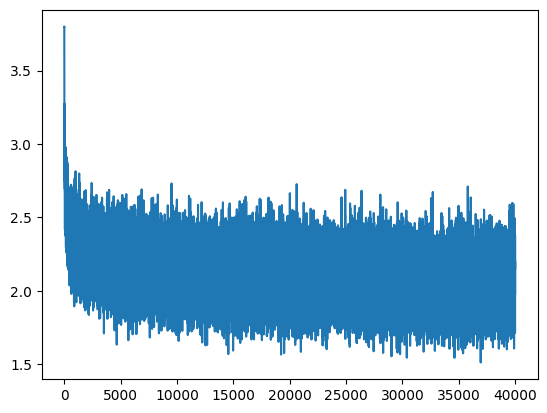

In [20]:
loss_list = train_MLP(Xt, Yt, model, batch_size, epochs, lr)
plt.plot(loss_list)

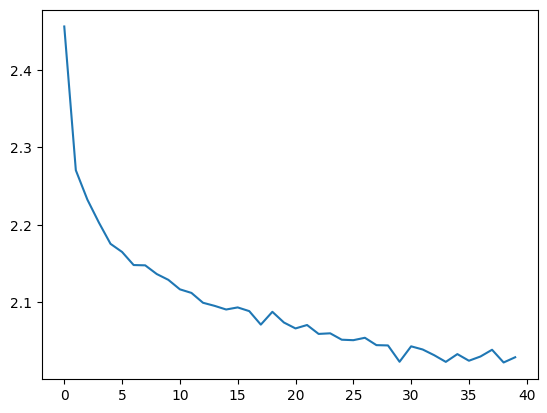

In [21]:
plt.plot(torch.tensor(loss_list).view(-1, 1000).mean(1))

In [22]:
for layer in model.layers:
    if isinstance(layer, BN1d):
        layer.training = False

In [23]:
def dev_MLP(X, Y, model):
    with torch.no_grad():
        logits = model(X)
        loss = F.cross_entropy(logits, Y)
        print(loss.item())

In [24]:
dev_MLP(Xdev, Ydev, model)

2.0842881202697754


## Infer

In [72]:
def infer_names(num, model): # Cant infer in parallel
    for i in range(num):
        result = []
        xx = [0] * chunk
        while True:
            logits = model(torch.tensor(xx).unsqueeze(0))
            probs = logits.exp() / logits.exp().sum(dim=1)
            next_token = torch.multinomial(probs[0], num_samples=1)
            result.append(next_token.item())
            xx = xx[1:] + [next_token]
            if next_token == 0:
                break
        result = [itos[char] for char in result]
        print(''.join(result))
    
infer_names(10, model)

aajeent.
humaijaha.
rayan.
graysen.
myckey.
luilah.
weyla.
avyneah.
tura.
lonneel.
